# Computing SHAP values and Jaccard Index Similarities

Author: Tesfagabir Meharizghi<br>
Last Updated: 01/05/2021

This notebook implements the following actions:
- Computes and saves SHAP values using different trained models (Simple LSTM, LSTM+Attention and XGB).
    * The number of background examples are configured. E.g., 500
    * Whether to use only negative examples as background
    * Since the SHAP value computation is slow, it also specifies the number of examples for test (N_TEST)
- It also computes the Jaccard similarity index between each model's shap values and visualizes it in HEATMAPS
    * It visualizes for different number of top k features
- It also computes the intersection similarity value between the ground truth helping events (helpers with suffix `_H` and Adverse with suffix `_A`) and the predicted helping events for each model.

Requirements:
- Please make sure that all the models are already trained and saved. You can use the [02_ToySimple_lstm-attn-training-shap-jacc.ipynb](02_ToySimple_lstm-attn-training-shap-jacc.ipynb) notebook to train and save the models

Data Used:
- It uses the toy_simple dataset with different sequence lengths (30, 300, 900)
- Sequence Lengths: 30, 300, 900
- Train Size: 18K, Val Size: 6K, Test Size: 6K

Observations of experiments
- The performances of the different models looks similar
- The intersection similarities results for the different sequence lengths were not consistent 

Any actions/next steps/thoughts/discussion
- As we couldn't get clear conclusions from these results, we will deep dive into the model training, parameter tuning, etc. as the next action item.
- For each model architecture, we will explore more on every step from model training, tuning, overtraining, shap values, intersection similarities, etc.
- Separate ipynbs are created for each model. E.g., go to [02_ToySimple_lstm-attn-training-shap-jacc.ipynb](02_ToySimple_lstm-attn-training-shap-jacc.ipynb) to check the results for LSTM+Attention model analysis



In [36]:
# pip install nb-black

In [37]:
#! jupyter nbextension enable jupyter-black-master/jupyter-black

#! pip install botocore==1.12.201

#! pip install shap
#! pip install xgboost

In [38]:
%load_ext lab_black

%load_ext autoreload

%autoreload 2

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import os
import time
import torch
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from urllib.parse import urlparse
import tarfile
import pickle
import shutil

import shap
import xgboost as xgb

import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.image_uris import retrieve

import deep_id_pytorch

from lstm_models import *
from att_lstm_models import *
from lstm_utils import *
from xgboost_utils import *
from shap_jacc_utils import *

## 1. LSTM Dataset and Model Loading

## Constants

In [40]:
nrows = 1e9
min_freq = 1

seq_len = 30

train_data_path = "../../data/toy_dataset/data/{}/train.csv".format(seq_len)
valid_data_path = "../../data/toy_dataset/data/{}/val.csv".format(seq_len)
test_data_path = "../../data/toy_dataset/data/{}/test.csv".format(seq_len)

lstm_shap_features_path = "./output/{}/shap/features/lstm_features.pkl".format(seq_len)
lstm_shap_scores_path = "./output/{}/shap/feature-importance/lstm_scores.pkl".format(
    seq_len
)
lstm_shap_patients_path = (
    "./output/{}/shap/feature-importance/lstm_patients.pkl".format(seq_len)
)

lstm_att_shap_features_path = "./output/{}/shap/features/lstm_att_features.pkl".format(
    seq_len
)
lstm_att_shap_scores_path = (
    "./output/{}/shap/feature-importance/lstm_att_scores.pkl".format(seq_len)
)
lstm_att_shap_patients_path = (
    "./output/{}/shap/feature-importance/lstm_att_patients.pkl".format(seq_len)
)

lstm_model_save_path = "./output/{}/lstm/models/model".format(seq_len)
lstm_results_save_path = "./output/{}/lstm/results/".format(seq_len)

lstm_att_model_save_path = "./output/{}/lstm-att/models/model".format(seq_len)
lstm_att_results_save_path = "./output/{}/lstm-att/results/".format(seq_len)

batch_size = 64

embedding_dim = 8
hidden_dim = 16
nlayers = 1
bidirectional = True
dropout = 0.3

target_colname = "label"
uid_colname = "patient_id"
x_inputs = [str(x) for x in range(seq_len - 1, -1, -1)]
target_value = "1"

rev = False

In [41]:
for fp in [lstm_model_save_path, lstm_results_save_path]:
    if not os.path.isdir(os.path.split(fp)[0]):
        print(f"New directory created: {fp}")
        os.makedirs(os.path.split(fp)[0])

for fp in [lstm_att_model_save_path, lstm_att_results_save_path]:
    if not os.path.isdir(os.path.split(fp)[0]):
        print(f"New directory created: {fp}")
        os.makedirs(os.path.split(fp)[0])

print(f"Cuda available: {torch.cuda.is_available()}")
model_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Cuda available: True


### Create Vocab and Build Dataset

In [42]:
train_dataset, vocab = build_lstm_dataset(
    train_data_path,
    min_freq=min_freq,
    uid_colname="patient_id",
    target_colname="label",
    max_len=seq_len,
    target_value=target_value,
    vocab=None,
    nrows=nrows,
    rev=rev,
)
valid_dataset, _ = build_lstm_dataset(
    valid_data_path,
    min_freq=min_freq,
    uid_colname="patient_id",
    target_colname="label",
    max_len=seq_len,
    target_value=target_value,
    vocab=vocab,
    nrows=nrows,
    rev=rev,
)

test_dataset, _ = build_lstm_dataset(
    test_data_path,
    min_freq=min_freq,
    uid_colname="patient_id",
    target_colname="label",
    max_len=seq_len,
    target_value=target_value,
    vocab=vocab,
    nrows=nrows,
    rev=rev,
)

Building dataset from ../../data/toy_dataset/data/30/train.csv..
Success!
Building dataset from ../../data/toy_dataset/data/30/val.csv..
Success!
Building dataset from ../../data/toy_dataset/data/30/test.csv..
Success!


In [43]:
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)

valid_dataloader = DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

### LSTM Model Loading and Evaluation

In [44]:
lstm_model = SimpleLSTM(
    embedding_dim, hidden_dim, vocab, model_device, nlayers=nlayers, dropout=dropout
)
lstm_model = lstm_model.cuda()

In [45]:
lstm_model

SimpleLSTM(
  (emb_layer): Embedding(32, 8, padding_idx=0)
  (lstm): LSTM(8, 16, batch_first=True, dropout=0.3, bidirectional=True)
  (pred_layer): Linear(in_features=32, out_features=1, bias=True)
  (dpt): Dropout(p=0.3, inplace=False)
)

In [46]:
# loss_function = nn.CrossEntropyLoss()
loss_function = nn.BCEWithLogitsLoss()

In [47]:
lstm_model.load_state_dict(torch.load(lstm_model_save_path))
test_loss, test_auc = epoch_val_lstm(
    lstm_model, test_dataloader, loss_function
)  # , return_preds=False

print(f"Test Loss: {test_loss:.3f} | Test AUC: {test_auc:.2f}")

Test Loss: 0.320 | Test AUC: 0.91


## 3. LSTM with Attention Model Loading and Evaluation

In [48]:
lstm_att_model = AttLSTM(
    embedding_dim, hidden_dim, vocab, model_device, nlayers=nlayers, dropout=dropout
)
lstm_att_model = lstm_att_model.cuda()

In [49]:
lstm_att_model

AttLSTM(
  (emb_layer): Embedding(32, 8, padding_idx=0)
  (lstm): LSTM(8, 16, batch_first=True, dropout=0.3, bidirectional=True)
  (pred_layer): Linear(in_features=64, out_features=1, bias=True)
  (attn_layer): Linear(in_features=32, out_features=1, bias=True)
  (dpt): Dropout(p=0.3, inplace=False)
  (context_layer): Linear(in_features=32, out_features=1, bias=True)
)

In [50]:
# loss_function = nn.CrossEntropyLoss()
loss_function = nn.BCEWithLogitsLoss()

In [51]:
lstm_att_model.load_state_dict(torch.load(lstm_att_model_save_path))
test_loss, test_auc = epoch_val_lstm(
    lstm_att_model, test_dataloader, loss_function
)  # , return_preds=False

print(f"Test Loss: {test_loss:.3f} | Test AUC: {test_auc:.2f}")

Test Loss: 0.329 | Test AUC: 0.90


## 2. XGBoost Dataset and Model Loading

### Data Preprocessing

In [52]:
x_train_one_hot_path = "output/{}/xgboost/data/train_one_hot.csv".format(seq_len)
x_valid_one_hot_path = "output/{}/xgboost/data/val_one_hot.csv".format(seq_len)
x_test_one_hot_path = "output/{}/xgboost/data/test_one_hot.csv".format(seq_len)

x_train_data_path = "output/{}/xgboost/data/train.csv".format(seq_len)
x_valid_data_path = "output/{}/xgboost/data/val.csv".format(seq_len)
x_test_data_path = "output/{}/xgboost/data/test.csv".format(seq_len)

s3_output_data_dir = "s3://merck-paper-bucket/{}/data".format(seq_len)

xgb_shap_features_path = "./output/{}/shap/features/xgb_features.pkl".format(seq_len)
xgb_shap_scores_path = "./output/{}/shap/feature-importance/xgb_scores.pkl".format(
    seq_len
)
xgb_shap_patients_path = "./output/{}/shap/feature-importance/xgb_patients.pkl".format(
    seq_len
)

BUCKET = "merck-paper-bucket"
DATA_PREFIX = "{}/data".format(seq_len)
MODEL_PREFIX = "{}/xgboost/model".format(seq_len)
label = "label"

output_results_path = "output/{}/xgboost/train/train_results.csv".format(seq_len)
local_model_dir = "output/{}/xgboost/models/"
s3_output_path = "s3://{}/{}/output".format(BUCKET, MODEL_PREFIX)

In [53]:
df = pd.read_csv(train_data_path)
print(df.shape)
df.head()

(18000, 33)


,index,29,28,27,26,25,24,23,22,21,...,7,6,5,4,3,2,1,0,label,patient_id
0,2060,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,normal_bmi_U,foot_pain_N,ACL_tear_N,cut_finger_N,headache_N,ACL_tear_N,cold_sore_N,low_salt_diet_U,0,WQT192TZIU
1,1873,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,hay_fever_N,dental_exam_N,cut_finger_N,normal_bmi_U,ACL_tear_N,headache_N,PCI_U,ACE_inhibitors_U,0,EHO31C693C
2,1402,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,ankle_sprain_N,ingrown_nail_N,cut_finger_N,ingrown_nail_N,foot_pain_N,cold_sore_N,ARR_A,furosemide_H,1,TREAOF36OI
3,2781,<pad>,<pad>,<pad>,<pad>,myopia_N,dental_exam_N,peanut_allergy_N,ankle_sprain_N,cold_sore_N,...,quad_injury_N,ACL_tear_N,foot_pain_N,quad_injury_N,annual_physical_N,ankle_sprain_N,cold_sore_N,low_salt_diet_U,0,TAF54R2M8X
4,812,<pad>,<pad>,<pad>,<pad>,headache_N,hay_fever_N,cardiac_rehab_U,hay_fever_N,dental_exam_N,...,dental_exam_N,quad_injury_N,ACL_tear_N,cut_finger_N,dental_exam_N,cold_sore_N,foot_pain_N,PCI_U,0,4F38DQWGDM


In [54]:
tokens = lstm_model.vocab._vocab
my_tokens = get_valid_tokens(tokens)

In [55]:
df.head()

,index,29,28,27,26,25,24,23,22,21,...,7,6,5,4,3,2,1,0,label,patient_id
0,2060,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,normal_bmi_U,foot_pain_N,ACL_tear_N,cut_finger_N,headache_N,ACL_tear_N,cold_sore_N,low_salt_diet_U,0,WQT192TZIU
1,1873,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,hay_fever_N,dental_exam_N,cut_finger_N,normal_bmi_U,ACL_tear_N,headache_N,PCI_U,ACE_inhibitors_U,0,EHO31C693C
2,1402,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,ankle_sprain_N,ingrown_nail_N,cut_finger_N,ingrown_nail_N,foot_pain_N,cold_sore_N,ARR_A,furosemide_H,1,TREAOF36OI
3,2781,<pad>,<pad>,<pad>,<pad>,myopia_N,dental_exam_N,peanut_allergy_N,ankle_sprain_N,cold_sore_N,...,quad_injury_N,ACL_tear_N,foot_pain_N,quad_injury_N,annual_physical_N,ankle_sprain_N,cold_sore_N,low_salt_diet_U,0,TAF54R2M8X
4,812,<pad>,<pad>,<pad>,<pad>,headache_N,hay_fever_N,cardiac_rehab_U,hay_fever_N,dental_exam_N,...,dental_exam_N,quad_injury_N,ACL_tear_N,cut_finger_N,dental_exam_N,cold_sore_N,foot_pain_N,PCI_U,0,4F38DQWGDM


In [56]:
prepare_data(
    train_data_path,
    x_train_one_hot_path,
    x_train_data_path,
    seq_len,
    target_colname,
    my_tokens,
    s3_output_data_dir,
)
prepare_data(
    valid_data_path,
    x_valid_one_hot_path,
    x_valid_data_path,
    seq_len,
    target_colname,
    my_tokens,
    s3_output_data_dir,
)
prepare_data(
    test_data_path,
    x_test_one_hot_path,
    x_test_data_path,
    seq_len,
    target_colname,
    my_tokens,
    s3_output_data_dir,
)

Sucess!
Sucess!
Sucess!


### Model Loading and Evaluation

In [57]:
df_train = pd.read_csv(x_train_one_hot_path)
df_test = pd.read_csv(x_test_one_hot_path)

In [58]:
print(df_train.shape)
df_train.head()

(18000, 32)


,patient_id,backache_N,cold_sore_N,ankle_sprain_N,cut_finger_N,low_salt_diet_U,normal_bmi_U,foot_pain_N,ACL_tear_N,headache_N,...,cardiac_rehab_U,high_creatinine_H,AMI_A,PH_A,CHF_A,pneumonia_H,resistent_hyp_H,apnea_H,tachycardia_H,label
0,WQT192TZIU,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,EHO31C693C,0,0,0,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,TREAOF36OI,1,1,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
3,TAF54R2M8X,0,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4F38DQWGDM,1,1,0,1,0,0,1,1,1,...,1,0,0,0,0,0,0,0,0,0


In [59]:
print(df_test.shape)
df_test.head()

(6000, 32)


,patient_id,backache_N,cold_sore_N,ankle_sprain_N,cut_finger_N,low_salt_diet_U,normal_bmi_U,foot_pain_N,ACL_tear_N,headache_N,...,cardiac_rehab_U,high_creatinine_H,AMI_A,PH_A,CHF_A,pneumonia_H,resistent_hyp_H,apnea_H,tachycardia_H,label
0,CYJGX2RI08,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,9GNM0PF7IQ,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,Y0I7UN86BT,1,1,1,1,0,1,1,1,1,...,1,0,0,0,0,0,0,0,1,1
3,9QPHAVVA7O,0,1,1,1,0,0,1,1,1,...,0,0,0,0,0,1,0,1,0,1
4,QYG71XZNIE,0,1,1,1,0,0,1,1,1,...,0,0,0,0,0,0,1,0,1,1


In [60]:
X_train = df_train.iloc[:, 1:-1]
X_test = df_test.iloc[:, 1:-1]

In [61]:
df_best = pd.read_csv(output_results_path)
df_best

,class,seq_len,val_auc,best_model_path
0,label,30,0.9027,s3://merck-paper-bucket/30/xgboost/model/outpu...


In [62]:
s3_best_model_path = df_best.iloc[0]["best_model_path"]
s3_best_model_path

's3://merck-paper-bucket/30/xgboost/model/output/sagemaker-xgboost-210103-1517-001-e562bbb5/output/model.tar.gz'

In [63]:
# Copy the best model from s3 to local
output_path = copy_model_from_s3(s3_best_model_path, local_model_dir)
# Load the copied model
xgb_model = load_model(output_path)

In [64]:
test_auc = xgb_model.eval(xgb.DMatrix(X_test.values, df_test[target_colname].values))
test_auc

'[0]\teval-auc:0.898667'

## 3. Compute SHAP values

In [80]:
# Constants for LSTM
LSTM_N_BACKGROUND = 500  # Number of background examples
LSTM_NEGATIVE_ONLY = True  # Whether to use negative examples as background
LSTM_N_TEST = 1  # Number of examples to compute shap values from

XGB_N_BACKGROUND = 500
XGB_NEGATIVE_ONLY = True
XGB_N_TEST = 1

In [81]:
print("Computing SHAP values for LSTM model...")
lstm_features, lstm_scores, lstm_patients = get_lstm_features_and_shap_scores(
    lstm_model,
    train_dataloader,
    test_dataloader,
    seq_len,
    lstm_shap_features_path,
    lstm_shap_scores_path,
    lstm_shap_patients_path,
    n_test=LSTM_N_TEST,
    n_background=LSTM_N_BACKGROUND,
    background_negative_only=LSTM_NEGATIVE_ONLY,
)

print("Computing SHAP values for LSTM with Attention model...")
(
    lstm_att_features,
    lstm_att_scores,
    lstm_att_patients,
) = get_lstm_features_and_shap_scores(
    lstm_att_model,
    train_dataloader,
    test_dataloader,
    seq_len,
    lstm_att_shap_features_path,
    lstm_att_shap_scores_path,
    lstm_att_shap_patients_path,
    n_test=LSTM_N_TEST,
    n_background=LSTM_N_BACKGROUND,
    background_negative_only=LSTM_NEGATIVE_ONLY,
)

print("Computing SHAP values for XGB model...")
xgb_features, xgb_scores, xgb_patients = get_xgboost_features_and_shap_scores(
    xgb_model,
    df_train,
    df_test,
    xgb_shap_features_path,
    xgb_shap_scores_path,
    xgb_shap_patients_path,
    n_test=XGB_N_TEST,
    n_background=XGB_N_BACKGROUND,
    background_negative_only=XGB_NEGATIVE_ONLY,
)
print("Successfully Completed!")

Computing SHAP values for LSTM model...


500it [00:00, 706.40it/s]
1000it [00:03, 273.94it/s]

saved ./output/30/shap/features/lstm_features.pkl pickle..
saved ./output/30/shap/feature-importance/lstm_scores.pkl pickle..
saved ./output/30/shap/feature-importance/lstm_patients.pkl pickle..
Computing SHAP values for LSTM with Attention model...



500it [00:00, 762.10it/s]
1000it [00:03, 281.28it/s]


saved ./output/30/shap/features/lstm_att_features.pkl pickle..
saved ./output/30/shap/feature-importance/lstm_att_scores.pkl pickle..
saved ./output/30/shap/feature-importance/lstm_att_patients.pkl pickle..
Computing SHAP values for XGB model...
saved ./output/30/shap/features/xgb_features.pkl pickle..
saved ./output/30/shap/feature-importance/xgb_scores.pkl pickle..
saved ./output/30/shap/feature-importance/xgb_patients.pkl pickle..
Successfully Completed!


### Visualize SHAP values for a single example

In [82]:
# Load features, scores & patient ids if necessary
lstm_features = load_pickle(lstm_shap_features_path)
lstm_scores = load_pickle(lstm_shap_scores_path)
lstm_patients = load_pickle(lstm_shap_patients_path)

lstm_att_features = load_pickle(lstm_att_shap_features_path)
lstm_att_scores = load_pickle(lstm_att_shap_scores_path)
lstm_att_patients = load_pickle(lstm_att_shap_patients_path)

xgb_features = load_pickle(lstm_shap_features_path)
xgb_scores = load_pickle(lstm_shap_scores_path)
xgb_patients = load_pickle(xgb_shap_patients_path)

In [83]:
# index of the patient where you get compute shap
idx = 0

In [84]:
# For LSTM Model
lstm_features1 = lstm_features[idx]
lstm_scores1 = lstm_scores[idx]
lstm_patient_id = lstm_patients[idx]
len(lstm_features1), len(lstm_scores1)

df_lstm_shap = pd.DataFrame(
    np.array([lstm_features1, lstm_scores1]).T, columns=["events", "shap_vals"]
)
df_lstm_shap["shap_vals"] = pd.to_numeric(df_lstm_shap["shap_vals"])
print(df_lstm_shap.shape)
df_lstm_shap.head()

(8, 2)


,events,shap_vals
0,myopia_N,0.011266
1,annual_physical_N,0.003036
2,annual_physical_N,-0.004109
3,myopia_N,-0.003271
4,annual_physical_N,-0.002977


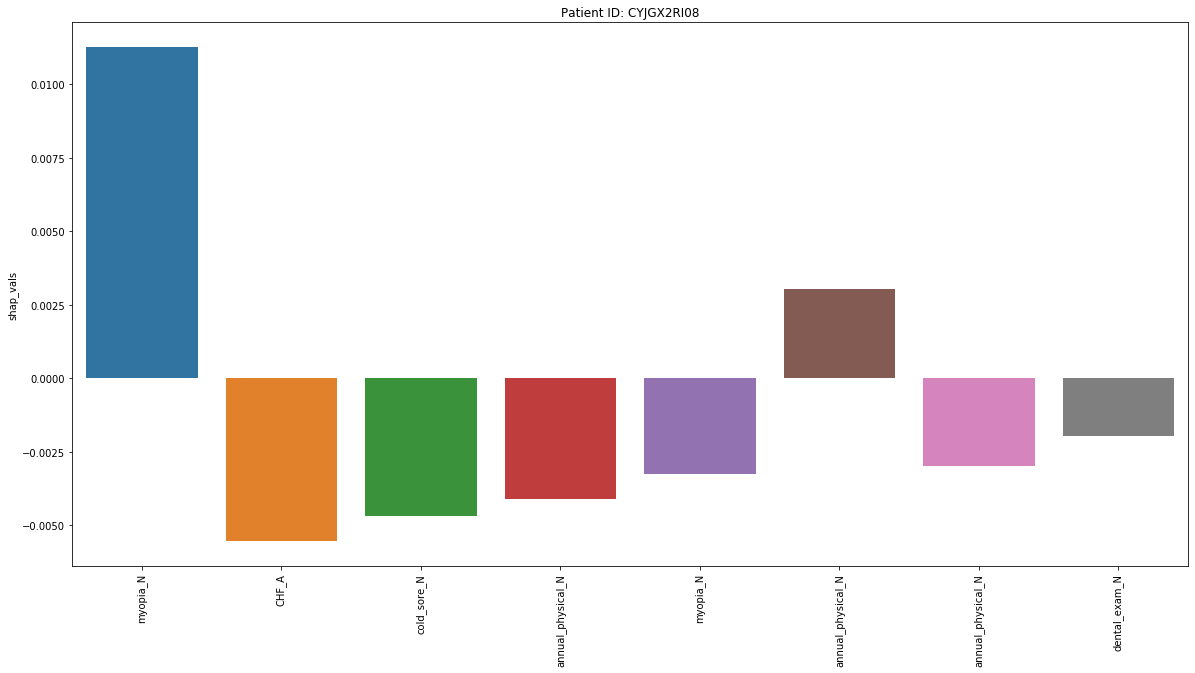

In [85]:
plot_shap_values(df_lstm_shap, lstm_patient_id, sort=True)

In [86]:
# For LSTM+Attention Model
lstm_att_features1 = lstm_att_features[idx]
lstm_att_scores1 = lstm_att_scores[idx]
lstm_att_patient_id = lstm_att_patients[idx]
len(lstm_att_features1), len(lstm_att_scores1)

df_lstm_att_shap = pd.DataFrame(
    np.array([lstm_att_features1, lstm_att_scores1]).T, columns=["events", "shap_vals"]
)
df_lstm_att_shap["shap_vals"] = pd.to_numeric(df_lstm_att_shap["shap_vals"])
print(df_lstm_att_shap.shape)
df_lstm_att_shap.head()

(8, 2)


,events,shap_vals
0,myopia_N,0.013018
1,annual_physical_N,0.008476
2,annual_physical_N,0.003060
3,myopia_N,-0.002326
4,annual_physical_N,0.002022


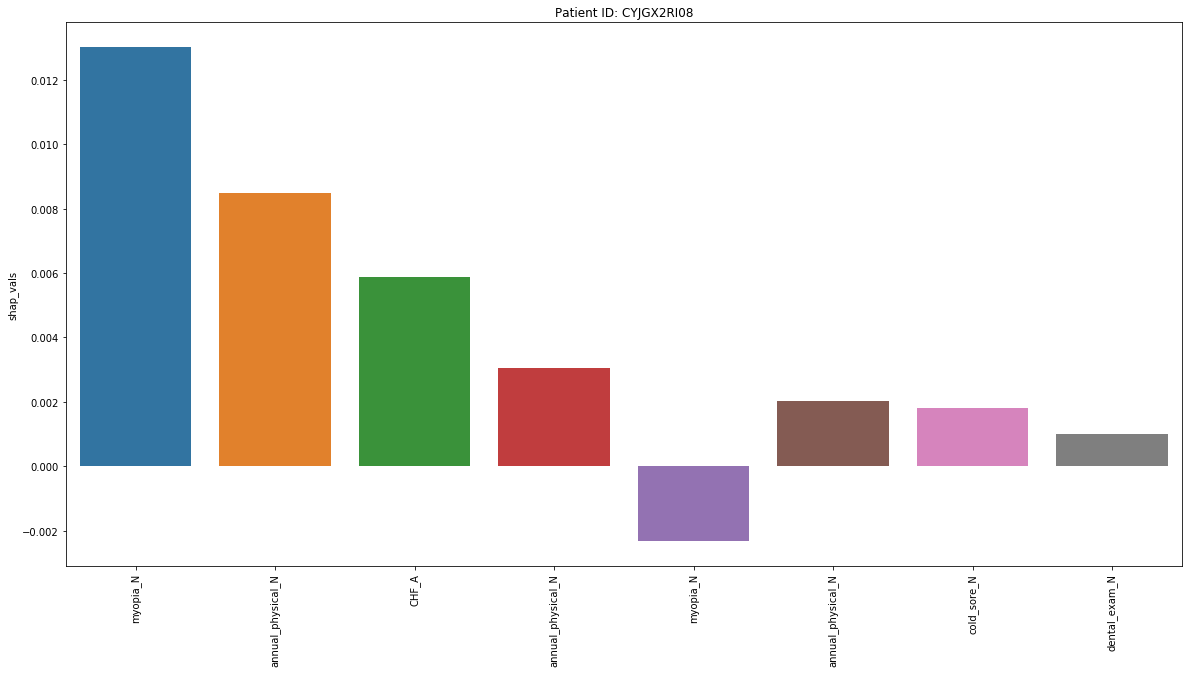

In [87]:
plot_shap_values(df_lstm_att_shap, lstm_att_patient_id, sort=True)

In [88]:
# For XGB Model
xgb_features1 = xgb_features[idx]
xgb_scores1 = xgb_scores[idx]
xgb_patient_id = xgb_patients[idx]
len(xgb_features1), len(xgb_scores1)

df_xgb_shap = pd.DataFrame(
    np.array([xgb_features1, xgb_scores1]).T, columns=["events", "shap_vals"]
)
df_xgb_shap["shap_vals"] = pd.to_numeric(df_xgb_shap["shap_vals"])
print(df_xgb_shap.shape)
df_xgb_shap.head()

(8, 2)


,events,shap_vals
0,myopia_N,0.011266
1,annual_physical_N,0.003036
2,annual_physical_N,-0.004109
3,myopia_N,-0.003271
4,annual_physical_N,-0.002977


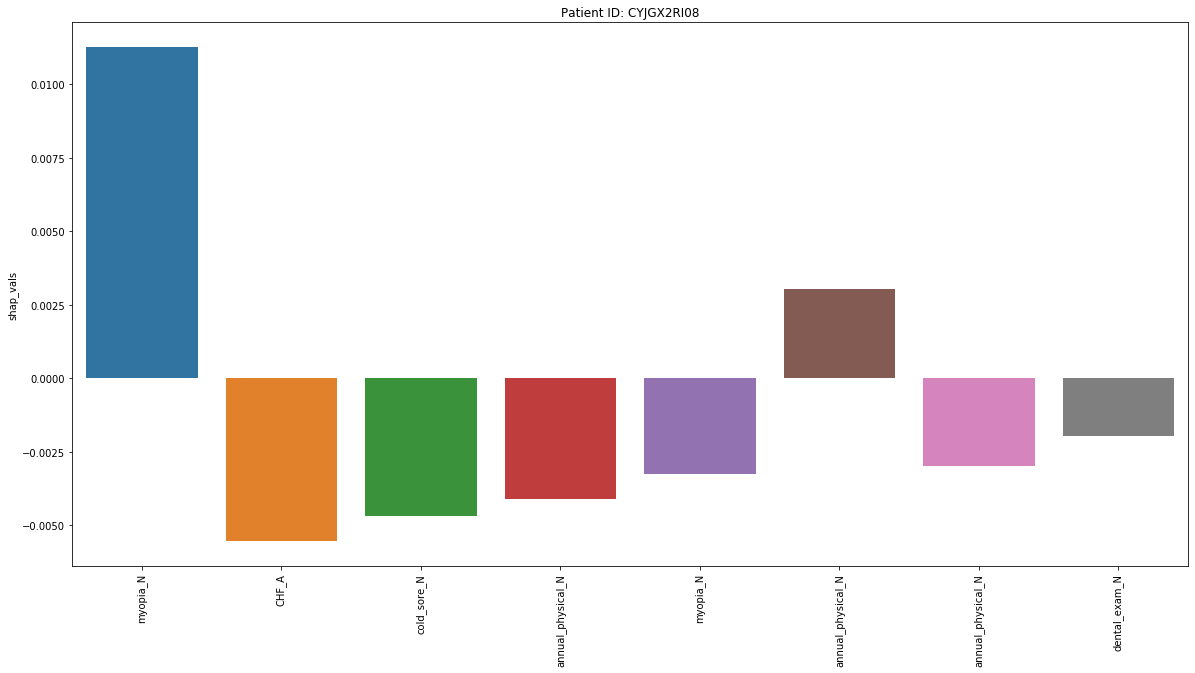

In [89]:
plot_shap_values(df_xgb_shap, xgb_patient_id, sort=True)

## Computing Jaccard Index Similarity b/n Models SHAP Values

In [90]:
k = 5  # Number of top k features
k_list = range(1, 11)
models = ["lstm", "lstm-att", "xgb"]

In [91]:
lstm_features = load_pickle(lstm_shap_features_path)
lstm_scores = load_pickle(lstm_shap_scores_path)
lstm_features_scores = (lstm_features, lstm_scores)

lstm_att_features = load_pickle(lstm_att_shap_features_path)
lstm_att_scores = load_pickle(lstm_att_shap_scores_path)
lstm_att_features_scores = (lstm_att_features, lstm_att_scores)

xgb_features = load_pickle(xgb_shap_features_path)
xgb_scores = load_pickle(xgb_shap_scores_path)
xgb_features_scores = (xgb_features, xgb_scores)

all_features_scores = [
    lstm_features_scores,
    lstm_att_features_scores,
    xgb_features_scores,
]

In [92]:
len(lstm_features), len(lstm_att_features), len(xgb_features)

(1, 1, 1)

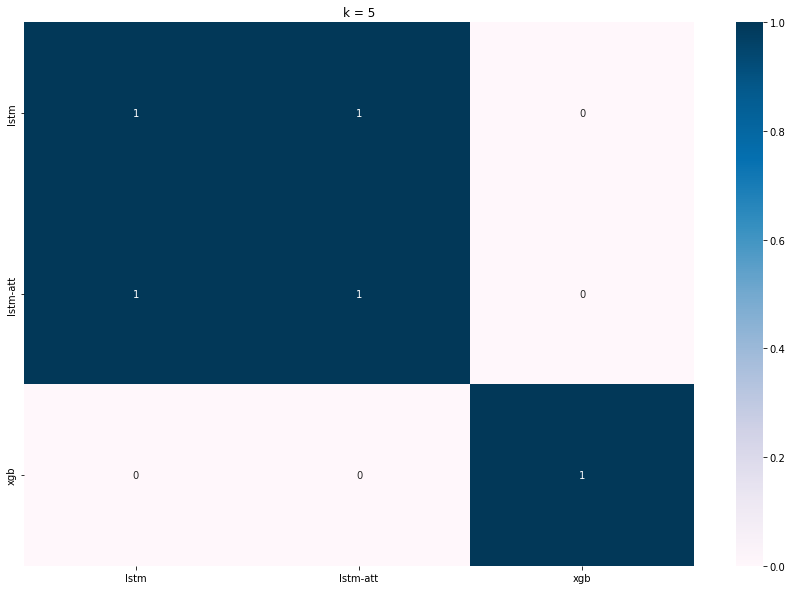

In [93]:
generate_heatmap(all_features_scores, models, k)

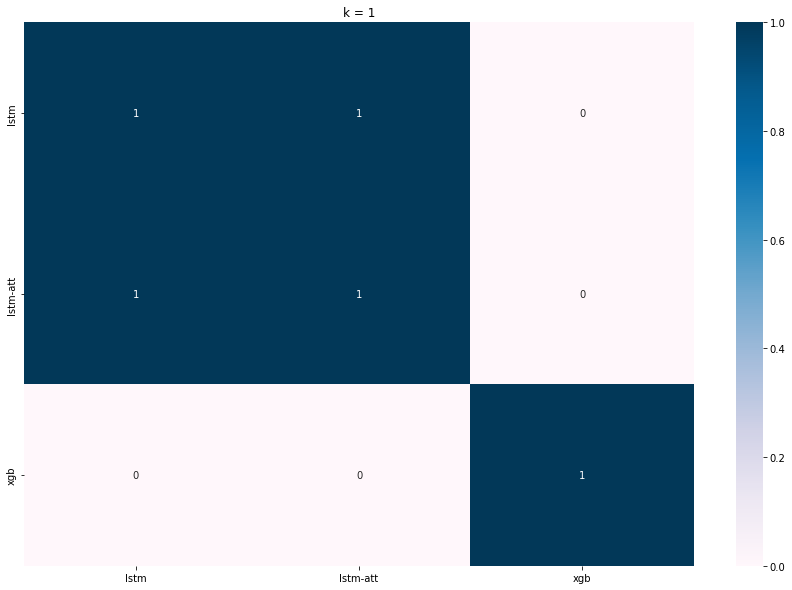

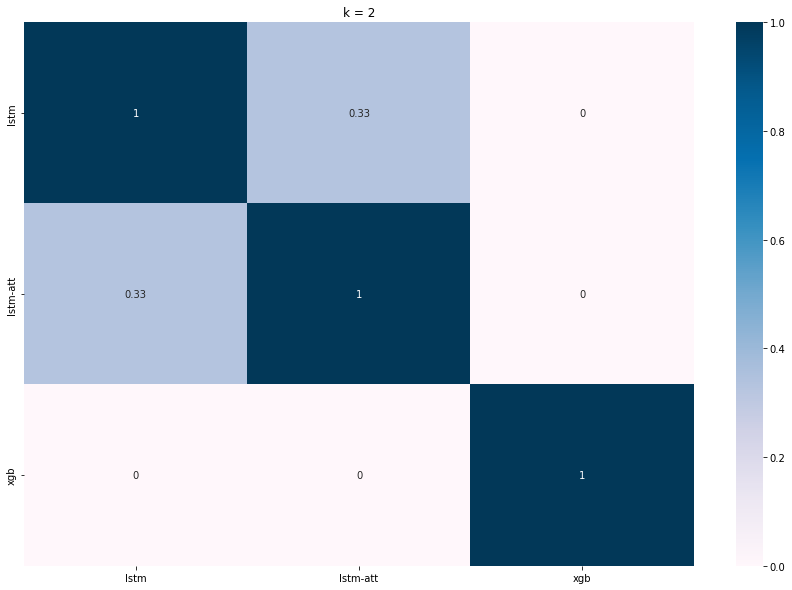

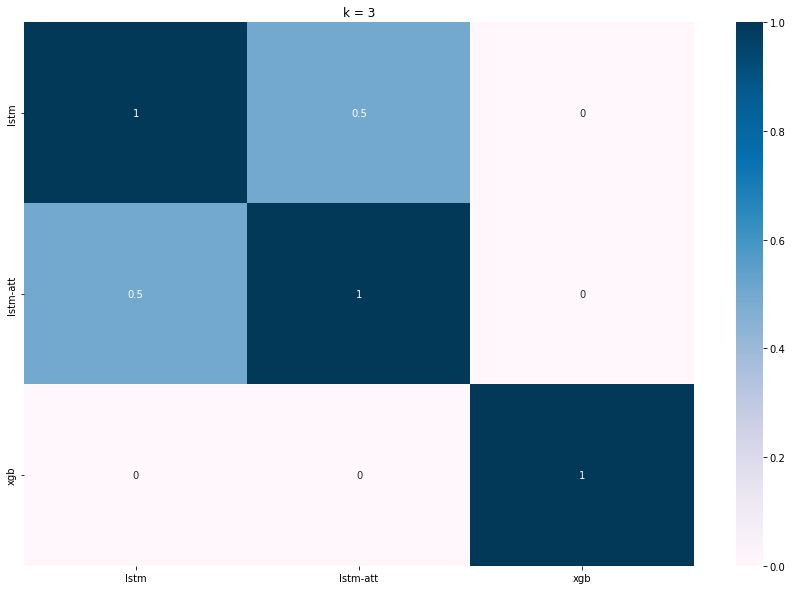

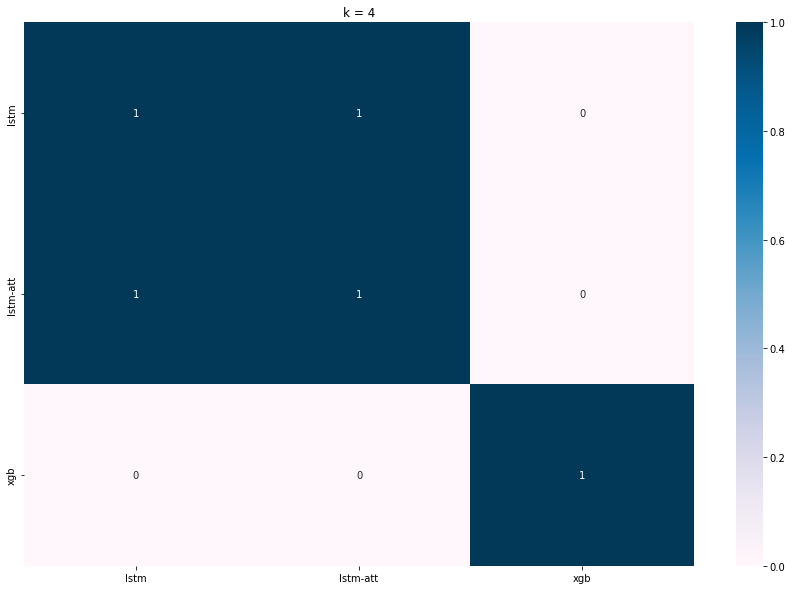

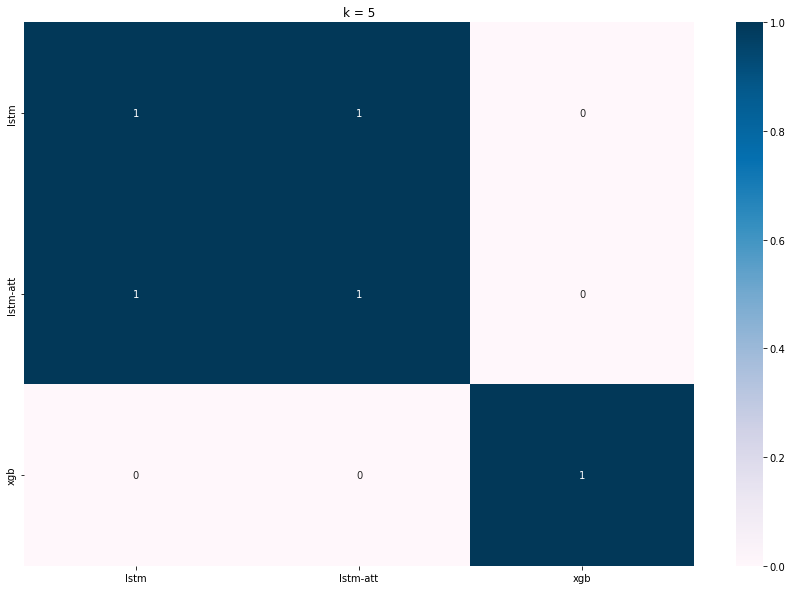

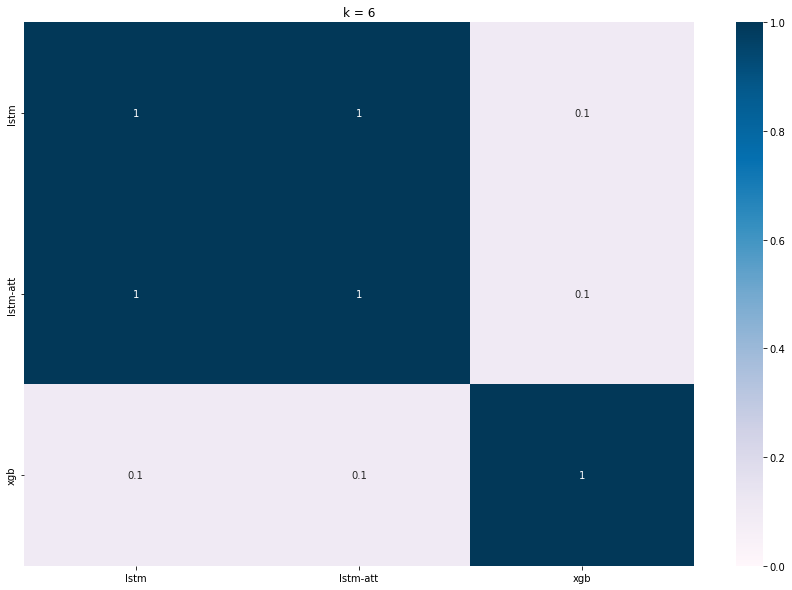

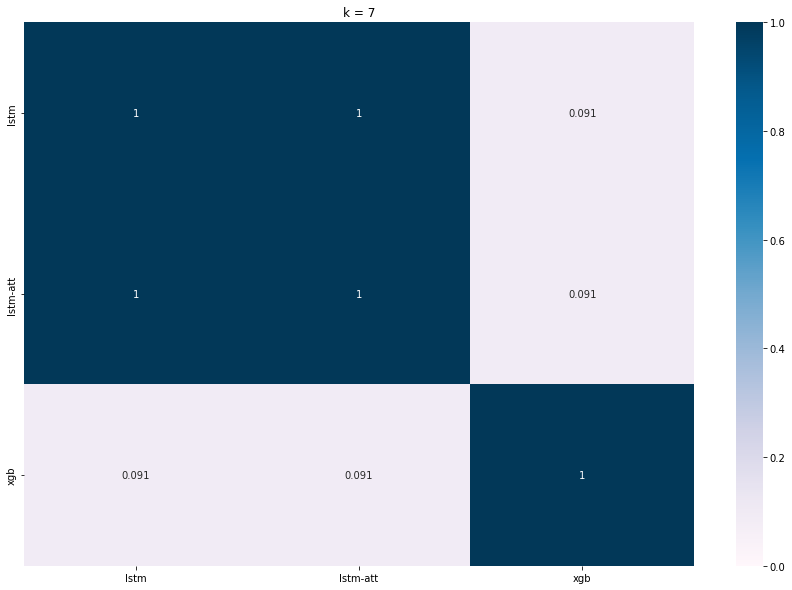

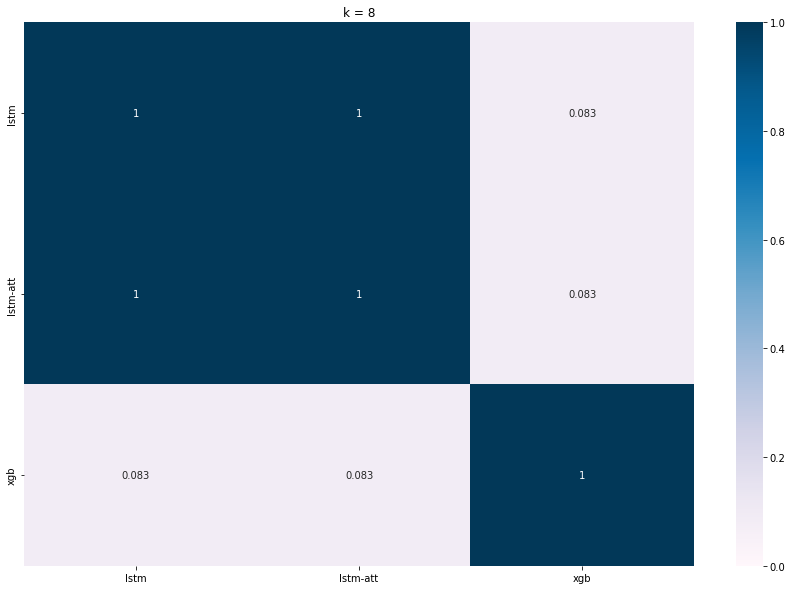

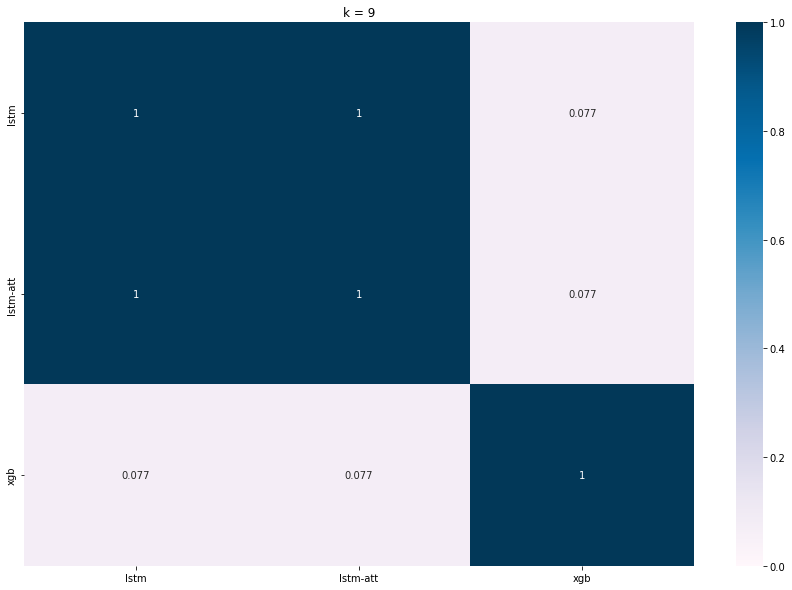

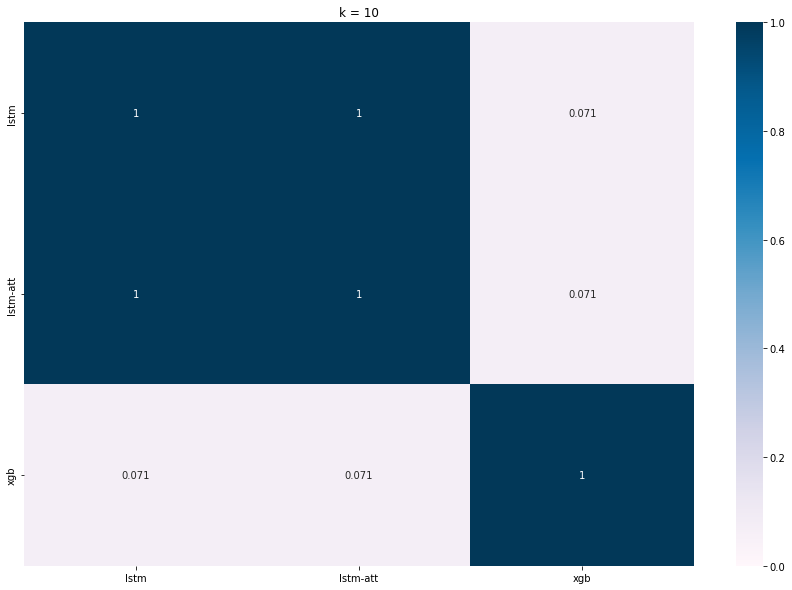

In [94]:
generate_k_heatmaps(all_features_scores, models, k_list)

## Intersection Similarity Score

This score computes the fraction of the intersection of the Ground Truth of Helpers+Adverse Events and Predicted Helpers+Adverse Events by Total Number of Helping Events.

In [95]:
# For LSTM
avg_sim, lstm_sim = get_model_intersection_similarity(lstm_features_scores)
print("Average Intersection Similarity(LSTM): {}".format(avg_sim))

# For LSTM+Attention
avg_sim, lstm_att_sim = get_model_intersection_similarity(lstm_att_features_scores)
print("Average Intersection Similarity(LSTM+Attention): {}".format(avg_sim))

# For XGB
avg_sim, xgb_sim = get_model_intersection_similarity(xgb_features_scores)
print("Average Intersection Similarity(XGB): {}".format(avg_sim))

Average Intersection Similarity(LSTM): 1.0
Average Intersection Similarity(LSTM+Attention): 1.0
Average Intersection Similarity(XGB): 0.1


```
For seq_len=30 (test batch_size=64), results are as follows:
    Average Intersection Similarity(LSTM): 0.14062499999999997
    Average Intersection Similarity(LSTM+Attention): 0.15625
    Average Intersection Similarity(XGB): 0.10781249999999994
For seq_len=300 (test batch_size=64), results are as follows:
    Average Intersection Similarity(LSTM): 0.24739583333333334
    Average Intersection Similarity(LSTM+Attention): 0.1953125
    Average Intersection Similarity(XGB): 0.4703124999999999
```

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

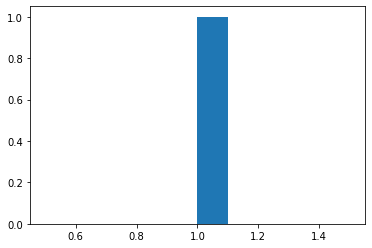

In [96]:
plt.hist(lstm_sim)

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

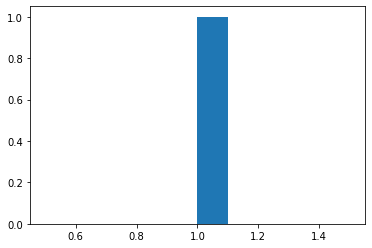

In [97]:
plt.hist(lstm_att_sim)

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6]),
 <a list of 10 Patch objects>)

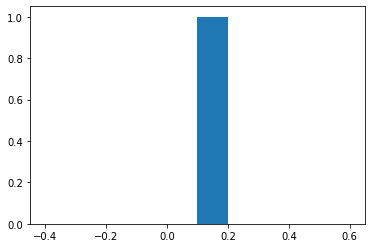

In [98]:
plt.hist(xgb_sim)